### Import Requirements

In [22]:
%matplotlib inline

import pandas as pd
pd.set_option('chained_assignment',None)
import numpy as np
import itertools
from collections import Counter
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

import re
import string
import codecs

from nltk.corpus import stopwords

# model prep and evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, classification_report

# machine learning algorithms
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

### Helper Functions

In [6]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Text Preprocessing

In [12]:
# Training data
df_train = pd.read_csv("../data/train_balanced.csv")
df_train = standardize_text(df_train, "sentence")

# Testing data
df_test = pd.read_csv("../data/test_balanced.csv")
df_test = standardize_text(df_test, "sentence")

### Data Transformations

In [15]:
# select data fields
X_train, X_test = df_train['sentence'], df_test['sentence']
y_train, y_test = df_train['author'], df_test['author']

# intialize the bag-of-words vectorizer
bow_vectorizer = CountVectorizer()

# fit and transform the training data
X_train_bow = bow_vectorizer.fit_transform(X_train)
# transform the testing data
X_test_bow = bow_vectorizer.transform(X_test)

print(X_train_bow.shape, X_test_bow.shape)

(1500, 5385) (600, 5385)


### Logistic Regression

Predicted value distribution: {'Hamilton': 271, 'Madison': 329}
             precision    recall  f1-score   support

   Hamilton      0.675     0.610     0.641       300
    Madison      0.644     0.707     0.674       300

avg / total      0.660     0.658     0.658       600



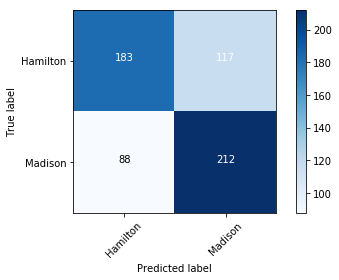

In [19]:
# Naive Bayes model fitting
lr = LogisticRegression()
lr.fit(X_train_bow, y_train)

# prediction
y_test_predict = lr.predict(X_test_bow)
print('Predicted value distribution:', dict(Counter(y_test_predict)))

# evaluation
print(classification_report(y_test, y_test_predict, digits=3))

cnf_matrix = confusion_matrix(y_test, y_test_predict)
plot_confusion_matrix(cnf_matrix, classes=['Hamilton','Madison'], normalize=False)
plt.show()

### Logistic Regression with Grid Search

In [52]:
C = np.logspace(-2, 2, num=100)
C

array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.05385551e-02, 3.35160265e-02, 3.67837977e-02, 4.03701726e-02,
       4.43062146e-02, 4.86260158e-02, 5.33669923e-02, 5.85702082e-02,
       6.42807312e-02, 7.05480231e-02, 7.74263683e-02, 8.49753436e-02,
       9.32603347e-02, 1.02353102e-01, 1.12332403e-01, 1.23284674e-01,
       1.35304777e-01, 1.48496826e-01, 1.62975083e-01, 1.78864953e-01,
       1.96304065e-01, 2.15443469e-01, 2.36448941e-01, 2.59502421e-01,
       2.84803587e-01, 3.12571585e-01, 3.43046929e-01, 3.76493581e-01,
       4.13201240e-01, 4.53487851e-01, 4.97702356e-01, 5.46227722e-01,
       5.99484250e-01, 6.57933225e-01, 7.22080902e-01, 7.92482898e-01,
       8.69749003e-01, 9.54548457e-01, 1.04761575e+00, 1.14975700e+00,
       1.26185688e+00, 1.38488637e+00, 1.51991108e+00, 1.66810054e+00,
      

In [53]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(-2, 2, num=100)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(lr, hyperparameters, cv=5, verbose=1)

# Fit grid search
best_model = clf.fit(X_train_bow, y_train)

# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best Penalty: l2
Best C: 0.16297508346206444


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   22.6s finished


Predicted value distribution: {'Hamilton': 261, 'Madison': 339}
             precision    recall  f1-score   support

   Hamilton      0.682     0.593     0.635       300
    Madison      0.640     0.723     0.679       300

avg / total      0.661     0.658     0.657       600



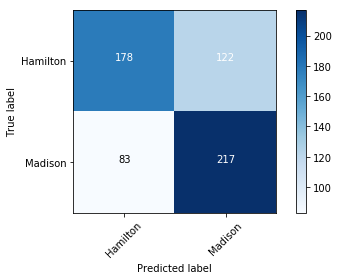

In [51]:
# Naive Bayes model fitting
lr = LogisticRegression(penalty='l2', C=0.17)
lr.fit(X_train_bow, y_train)

# prediction
y_test_predict = lr.predict(X_test_bow)
print('Predicted value distribution:', dict(Counter(y_test_predict)))

# evaluation
print(classification_report(y_test, y_test_predict, digits=3))

cnf_matrix = confusion_matrix(y_test, y_test_predict)
plot_confusion_matrix(cnf_matrix, classes=['Hamilton','Madison'], normalize=False)
plt.show()